In [ ]:
import pandas as pd
# importing matplotlib library
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, LearningCurveDisplay, ShuffleSplit
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import imblearn
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import pickle
from joblib  import Parallel, delayed
import joblib 
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import pearsonr
from google.colab import drive
drive.mount('/content/drive')
from matplotlib.colors import Normalize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [ ]:
def plot_grid_scores(scores,gamma,C):
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(
        scores,
        interpolation="nearest",
        cmap=plt.cm.coolwarm,
        norm=MidpointNormalize(vmin=0.2, midpoint=0.92)
    )
    
    plt.colorbar()
    plt.xticks(np.arange(len(gamma)), gamma, rotation=45)
    plt.yticks(np.arange(len(C)), C)
    plt.title("Validation accuracy")
    # plt.show()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')

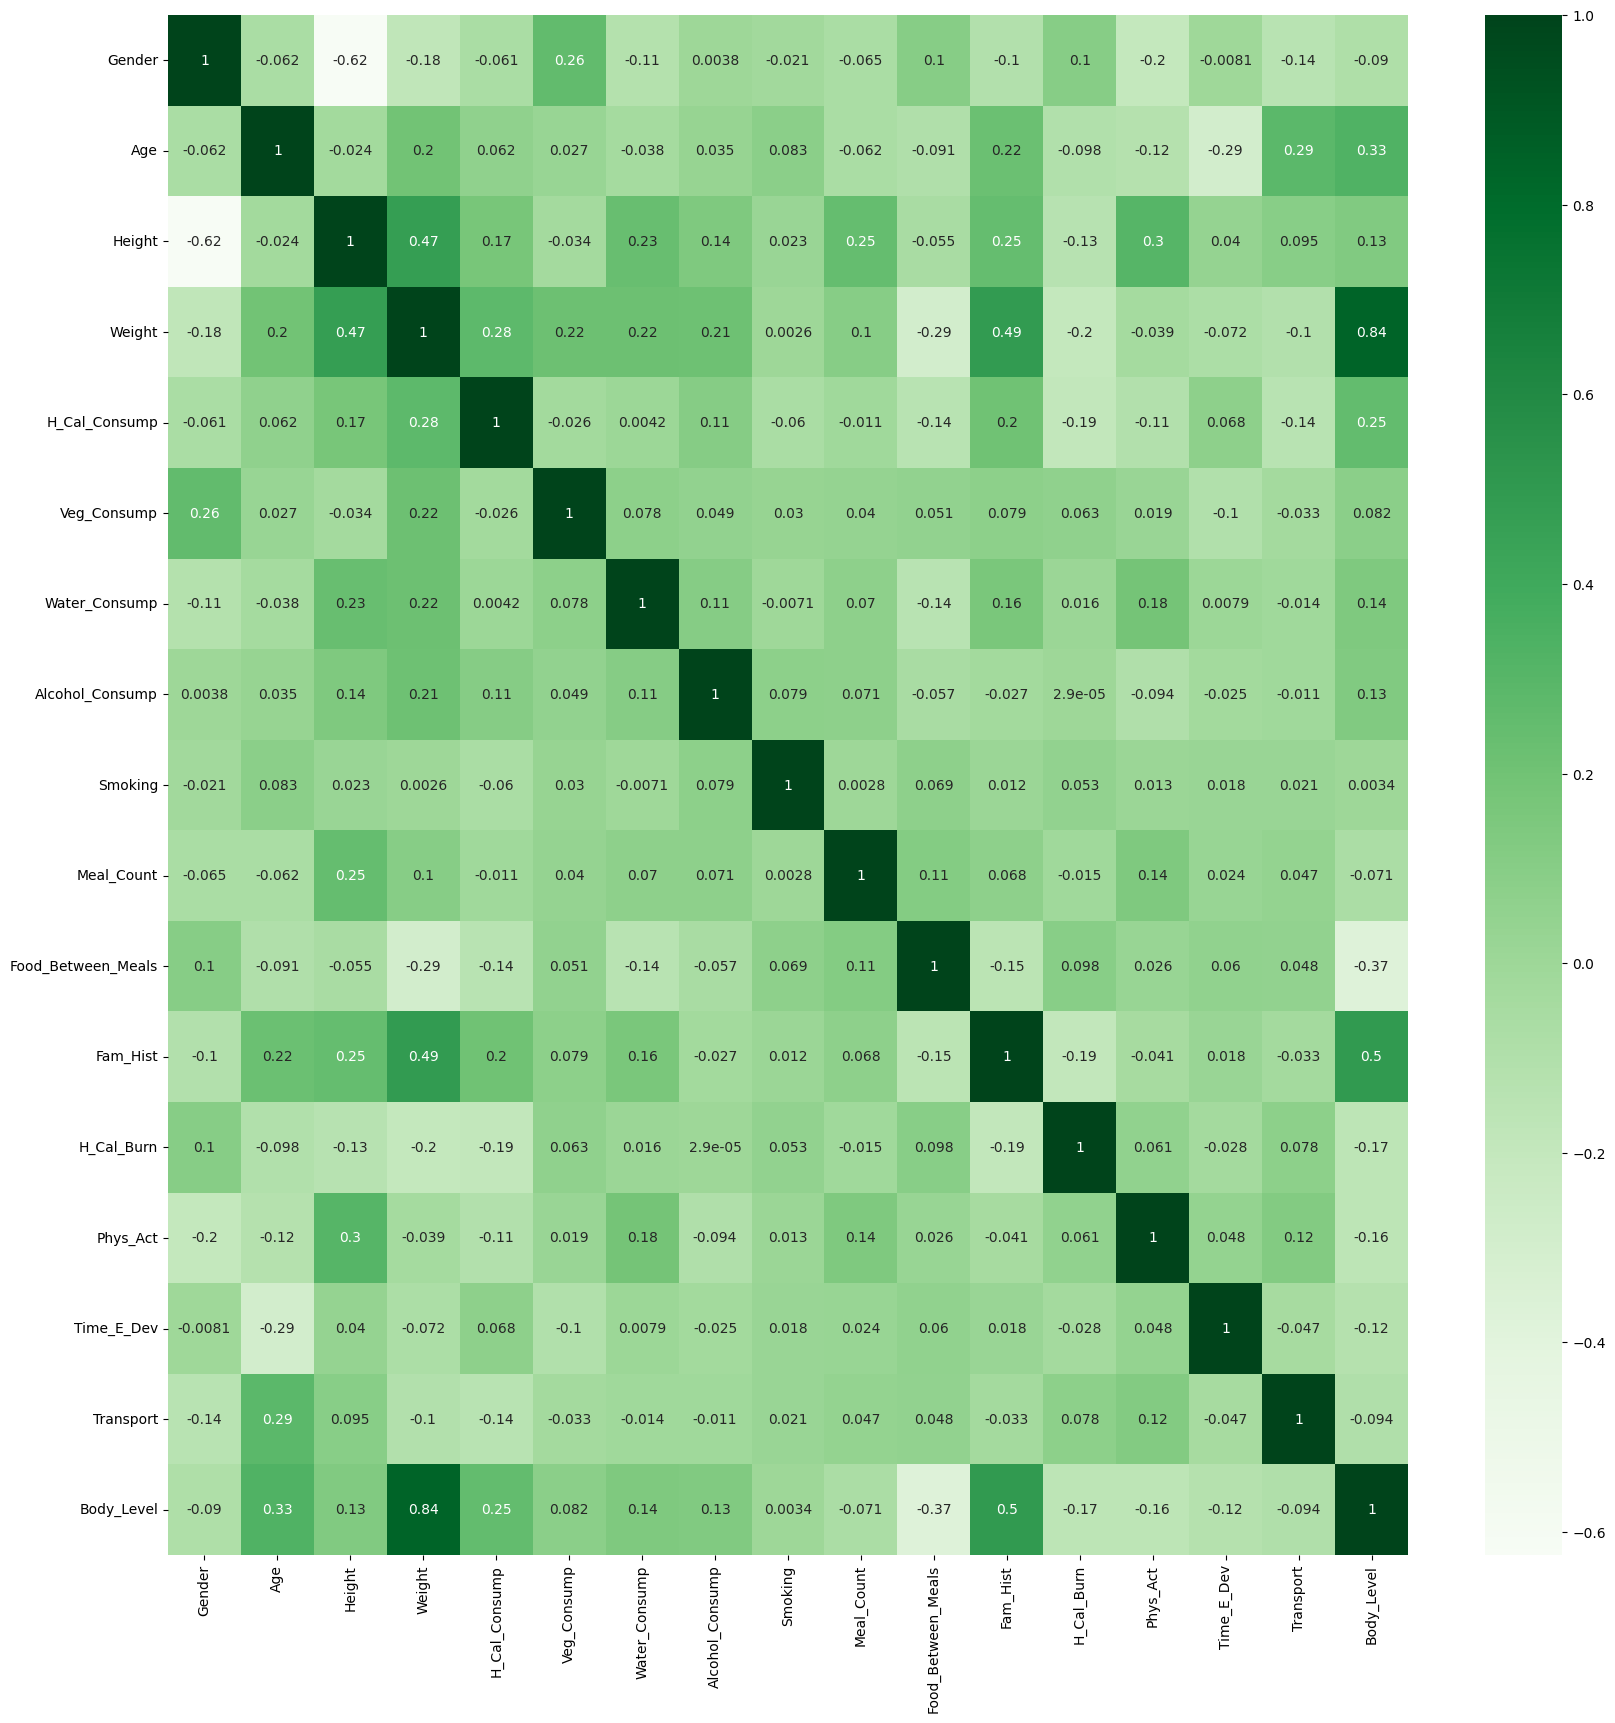

In [ ]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap="Greens",annot=True)
plt.show()


In [ ]:

oversample = SMOTE()
y=df['Body_Level']
X=df.loc[:, df.columns != 'Body_Level']

X0, y = oversample.fit_resample(X, y)



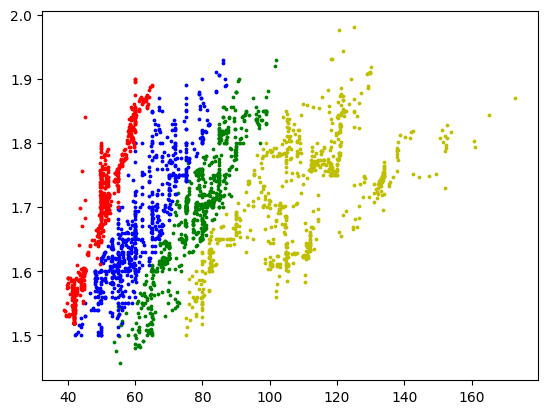

In [ ]:
w=X0['Weight']#(df['Height']**2)
h=X0['Height']
# y=y0
plt.scatter(w[y==4], h[y==4], s=3, c='y')
plt.scatter(w[y==3], h[y==3], s=3, c='g')
plt.scatter(w[y==2], h[y==2], s=3, c='b')
plt.scatter(w[y==1], h[y==1], s=3, c='r')

In [ ]:
from sklearn.model_selection import GridSearchCV

def train_Svm(X_train,y_train,S=True):
    C=[0.1, 1, 10, 100]
    gamma= [1, 0.1, 0.01, 0.001]
    param_grid = {'C': C, 
                  'gamma': gamma,
                  'kernel': ['rbf']
                  } 
      
    grid = GridSearchCV(svm.SVC(), param_grid, refit = True,cv=3)
  
    clf =  make_pipeline(StandardScaler(),grid)
    clf.fit(X_train,y_train)
    print(grid.best_params_)
    print(grid.best_estimator_)
    scores = grid.cv_results_["mean_test_score"].reshape(len(C), len(gamma))  
    plot_grid_scores(scores,gamma,C)
    plt.xlabel("gamma")
    plt.ylabel("C")
    if(S):
        joblib .dump(clf, '/content/drive/MyDrive/vm_mod1.pkl')
    else:
        return clf   
def inference(test,path='/content/drive/MyDrive/vm_mod'):
    mod1 = joblib .load(path+'1.pkl')
    y_pred =np.int16(mod1.predict(test))
    return y_pred

In [ ]:
def train_logisticRegression(X_train,y_train,S=True):
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    c=[0.1, 1, 10, 100]
    grid = dict(solver=solvers,C=c)
    grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=90000,tol=1e-5), param_grid=grid, scoring='accuracy',error_score=0)

    clf =  make_pipeline(StandardScaler(), grid_search)

    clf.fit(X_train,y_train)
    print(grid_search.best_params_)
    print(grid_search.best_estimator_)
    scores = grid_search.cv_results_["mean_test_score"].reshape(len(c), len(solvers))  
    plot_grid_scores(scores,solvers,c)
    plt.xlabel("solvers")
    plt.ylabel("C")
    if(S):
      joblib .dump(clf, '/content/drive/MyDrive/lr_mod1.pkl')
    else:
      return clf  
   
def lr_inference(test,path='/content/drive/MyDrive/lr_mod'):
    mod1 = joblib .load(path+'1.pkl')
    y_pred = mod1.predict(test)
    return y_pred

In [ ]:
X0['not_Fam_Hist']=1-X0['Fam_Hist']
# y=df['Body_Level']
X=X0[['Height','Weight','Fam_Hist','not_Fam_Hist', 'Food_Between_Meals','H_Cal_Consump','Age']]
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
SVC(C=100, gamma=0.01)


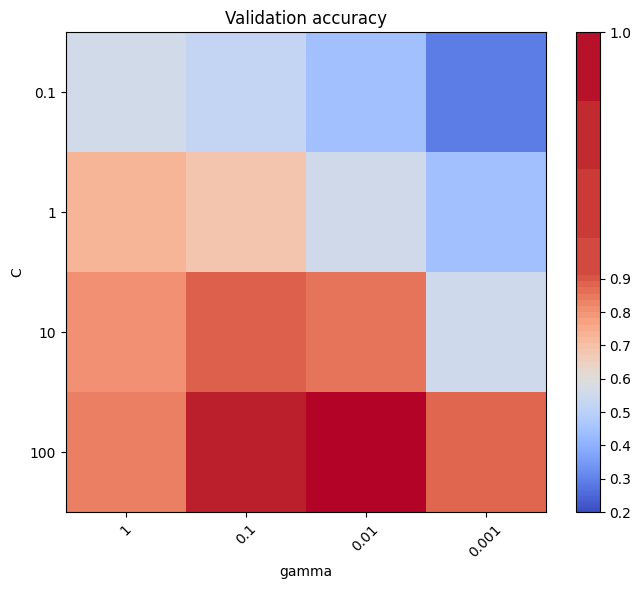

In [ ]:
clf=train_Svm(X_train,y_train,S=False)

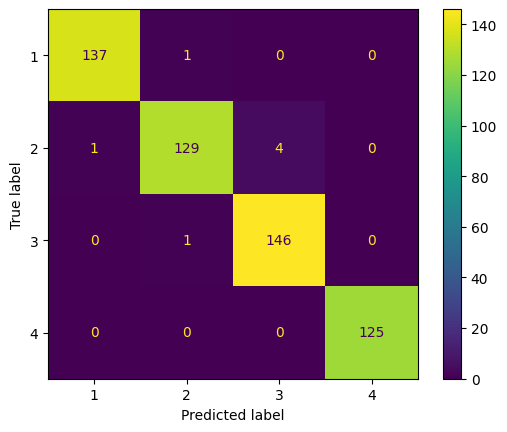

In [ ]:
y_pred=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=[1,2,3,4])
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       138
           2       0.98      0.96      0.97       134
           3       0.97      0.99      0.98       147
           4       1.00      1.00      1.00       125

    accuracy                           0.99       544
   macro avg       0.99      0.99      0.99       544
weighted avg       0.99      0.99      0.99       544



{'C': 100, 'solver': 'newton-cg'}
LogisticRegression(C=100, max_iter=90000, solver='newton-cg', tol=1e-05)


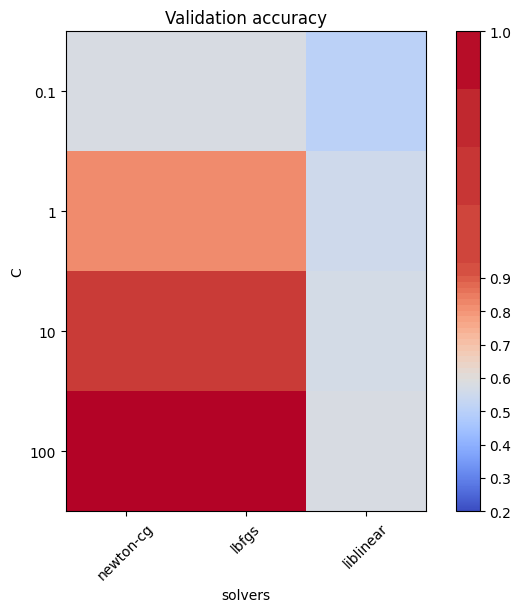

In [ ]:
clf=train_logisticRegression(X_train,y_train,S=False)

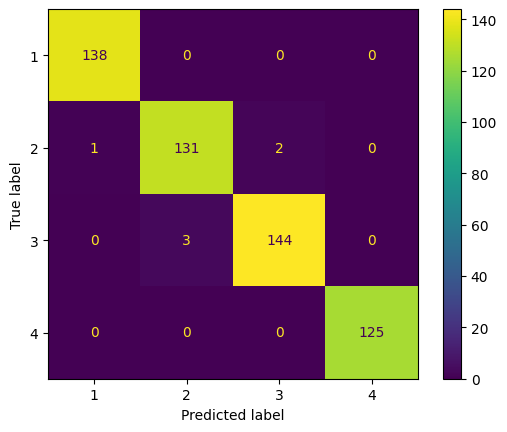

In [ ]:
y_pred=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=[1,2,3,4])
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       138
           2       0.98      0.98      0.98       134
           3       0.99      0.98      0.98       147
           4       1.00      1.00      1.00       125

    accuracy                           0.99       544
   macro avg       0.99      0.99      0.99       544
weighted avg       0.99      0.99      0.99       544



In [ ]:
X=X0[['Height','Weight','Fam_Hist','not_Fam_Hist']]

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=100, gamma=0.1)


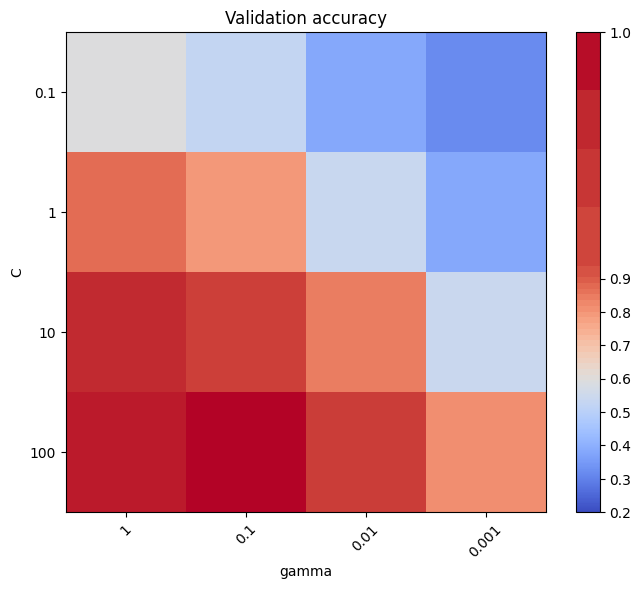

In [ ]:
 # y=df['Body_Level']
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=42)
clf_svm=train_Svm(X_train,y_train,S=False)

In [ ]:
y_pred=clf_svm.predict(X_test)

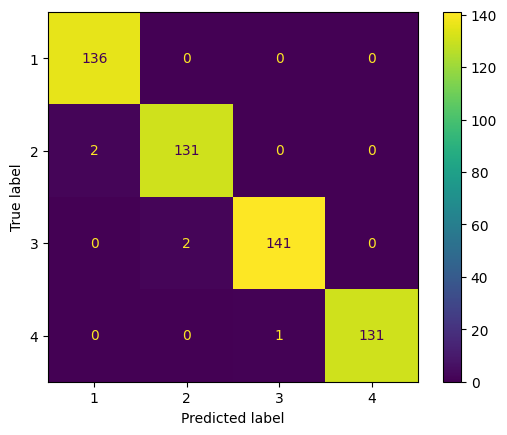

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=[1,2,3,4])
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       136
           2       0.98      0.98      0.98       133
           3       0.99      0.99      0.99       143
           4       1.00      0.99      1.00       132

    accuracy                           0.99       544
   macro avg       0.99      0.99      0.99       544
weighted avg       0.99      0.99      0.99       544



{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=100, gamma=0.1)


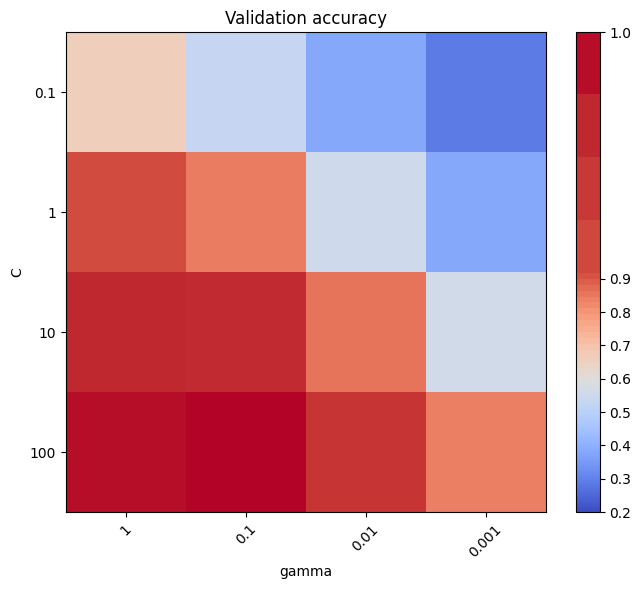

In [ ]:
train_Svm(X,y)

{'C': 100, 'solver': 'newton-cg'}
LogisticRegression(C=100, max_iter=90000, solver='newton-cg', tol=1e-05)


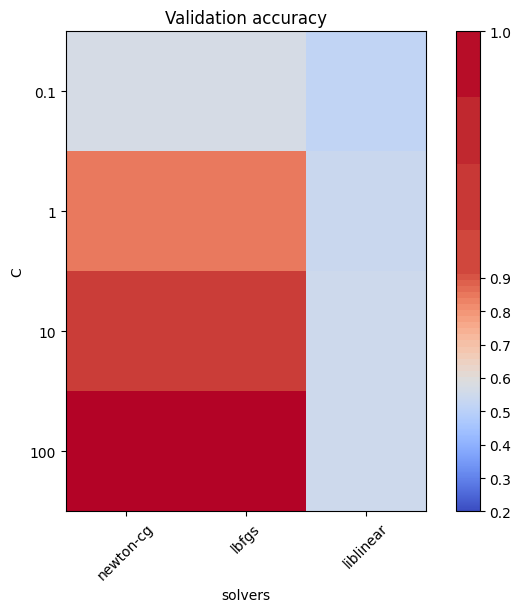

In [ ]:
# X=df[['Height','Weight','Fam_Hist','not_Fam_Hist']]
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.2,random_state=42)
clf_lr=train_logisticRegression(X_train ,y_train,S=False)

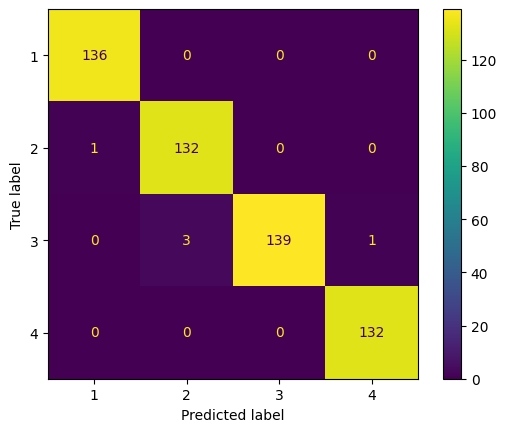

In [ ]:
y_pred=clf_lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=[1,2,3,4])
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       136
           2       0.98      0.99      0.99       133
           3       1.00      0.97      0.99       143
           4       0.99      1.00      1.00       132

    accuracy                           0.99       544
   macro avg       0.99      0.99      0.99       544
weighted avg       0.99      0.99      0.99       544



{'C': 100, 'solver': 'newton-cg'}
LogisticRegression(C=100, max_iter=90000, solver='newton-cg', tol=1e-05)


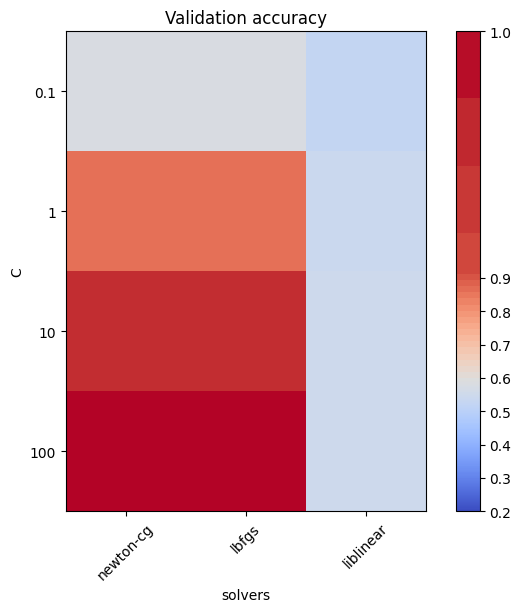

In [ ]:
train_logisticRegression(X, y)
# y_pred=lr_inference(X)
# print(classification_report(y,y_pred))

Text(0.5, 0, 'degree')

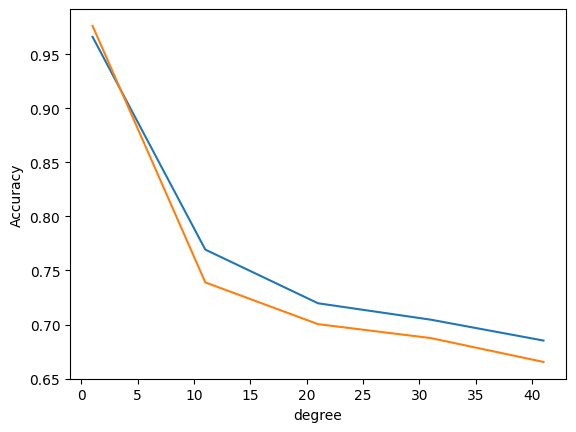

In [41]:
tr_acc=[]
degrees=[]
test_acc=[]
for i in range(1,50,10):
  degrees.append(i)
  clf=make_pipeline(StandardScaler(),svm.SVC(kernel='poly',degree=i ))
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_train)
  tr_acc.append(np.mean((y_train==y_pred)*1))
  y_pred=clf.predict(X_test)
  test_acc.append(np.mean((y_test==y_pred)*1))
plt.plot(degrees,tr_acc)
plt.plot(degrees,test_acc)
plt.ylabel('Accuracy')
plt.xlabel('degree')

Text(0.5, 0, 'C')

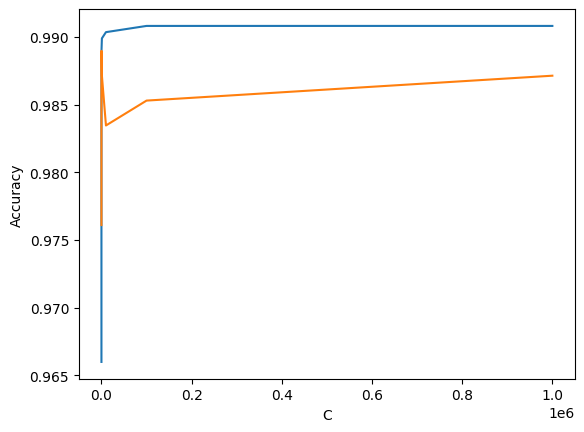

In [42]:
tr_acc=[]
C=[]
test_acc=[]
for i in range(7):
  c=10**i
  C.append(c)
  clf=make_pipeline(StandardScaler(),svm.SVC(kernel='poly',degree=1,C=c))
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_train)
  tr_acc.append(np.mean((y_train==y_pred)*1))
  y_pred=clf.predict(X_test)
  test_acc.append(np.mean((y_test==y_pred)*1))
  
plt.plot(C,tr_acc)
plt.plot(C,test_acc)
plt.ylabel('Accuracy')
plt.xlabel('C')

In [47]:
clf_svm_poly=make_pipeline(StandardScaler(),svm.SVC(kernel='poly',degree=1,C=2000))
clf_svm_poly.fit(X_train,y_train)
y_pred=clf_svm_poly.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       136
           2       0.97      1.00      0.99       133
           3       1.00      0.96      0.98       143
           4       0.99      1.00      0.99       132

    accuracy                           0.99       544
   macro avg       0.99      0.99      0.99       544
weighted avg       0.99      0.99      0.99       544



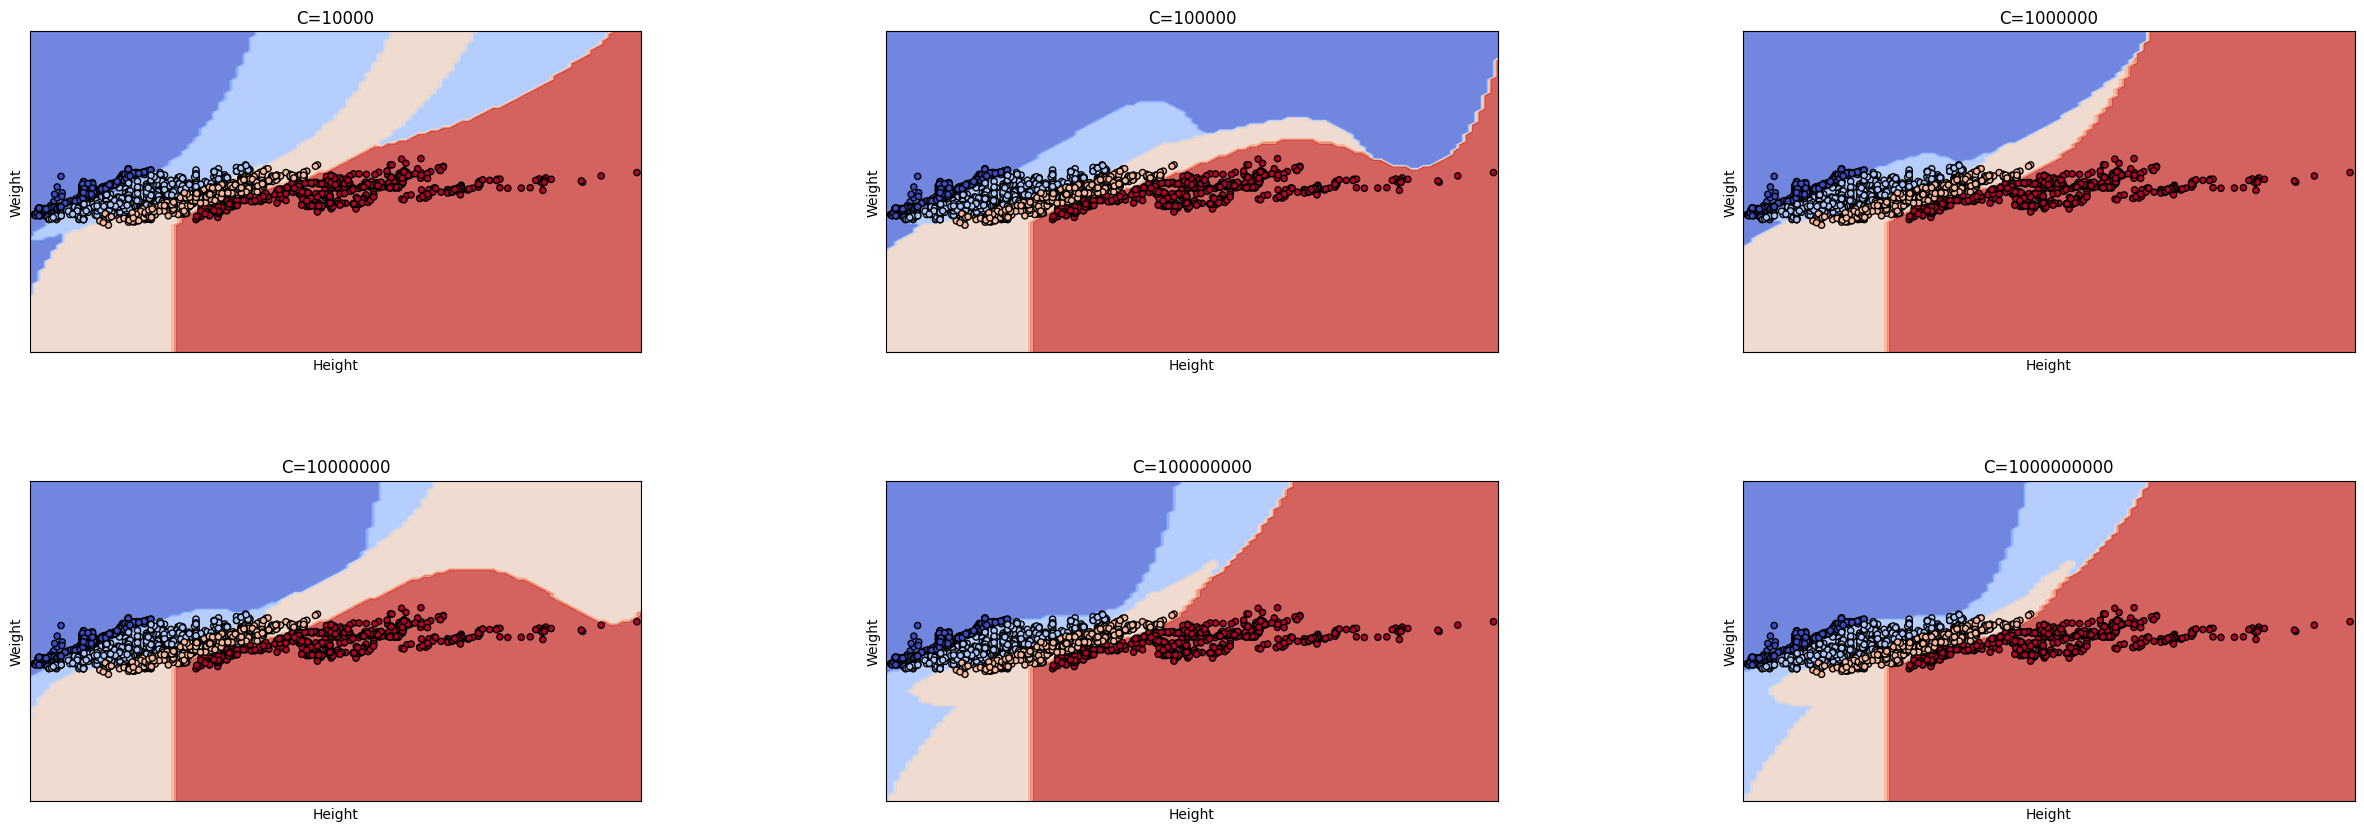

In [36]:
from sklearn.inspection import DecisionBoundaryDisplay

X_2=X[['Weight','Height' ]]
models = (
    svm.SVC(C=10000),
    svm.SVC(C=100000),
    svm.SVC(C=1000000),
    svm.SVC(C=10000000),
    svm.SVC(C=100000000),
    svm.SVC(C=1000000000),
)
models = (clf.fit(X_2, y) for clf in models)

# title for the plots
titles = (
    "C=10000",
    "C=100000",
    "C=1000000",
    "C=10000000",
    "C=100000000",
    "C=1000000000"
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(nrows=2, ncols=3, figsize=(30, 10), sharey=True)

plt.subplots_adjust(wspace=.4, hspace=.4)

X0, X1 = X_2['Weight'],X_2['Height'] 

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_2,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel='Height',
        ylabel='Weight',
     )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

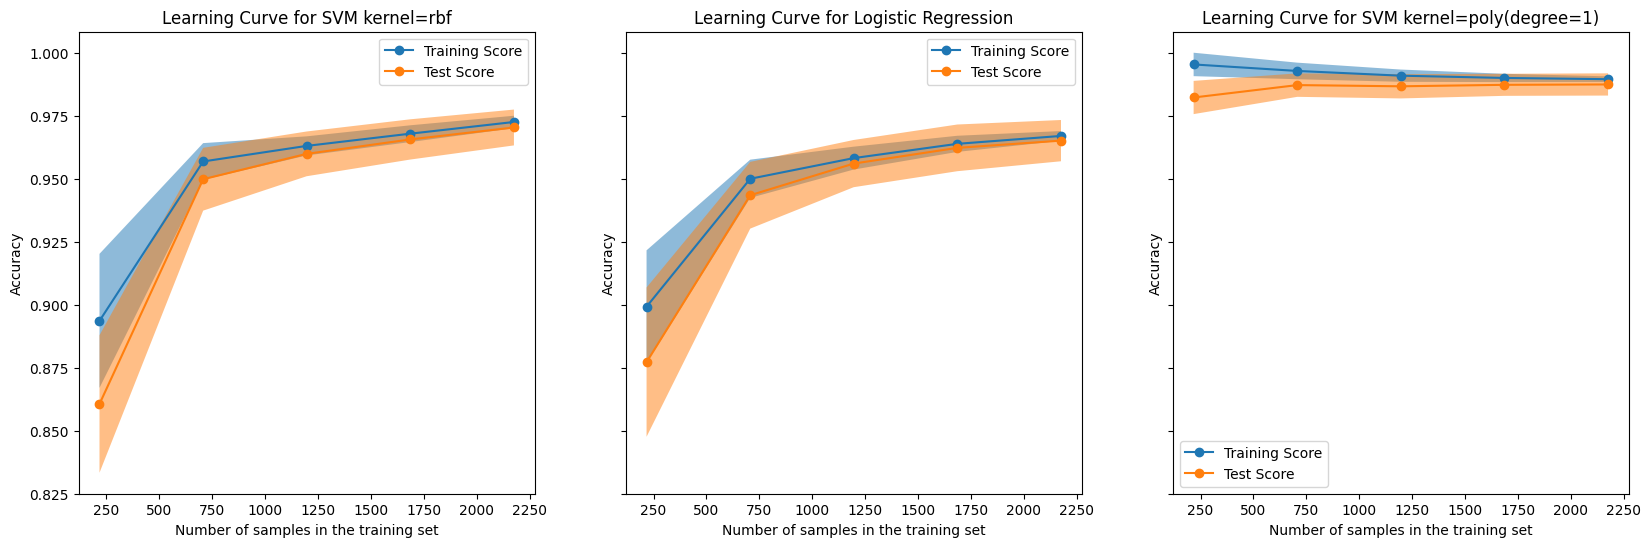

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharey=True)

# clf_lr=make_pipeline(StandardScaler(),LogisticRegression())
# clf_svm=make_pipeline(StandardScaler(),svm.SVC())

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}
names=['SVM kernel=rbf','Logistic Regression','SVM kernel=poly(degree=1)']
i=0
for ax_idx, estimator in enumerate([clf_svm, clf_lr, clf_svm_poly]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {names[i]}")
    i+=1